In [1]:
import data.credentials as credentials
from misc_twitter import print_score, clean_tweets

import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import re
import json

from sklearn.utils import shuffle, resample
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import joblib
from joblib import dump, load
from scipy import stats

# Sentiment Analysis on Tweets. 

### Maria Vogli
### Sarah Santos
### Esteban Ortega Lopez

Here we use the database on hatespeech on twitter found in https://github.com/SDS-AAU/SDS-master/raw/master/M2/data/twitter_hate.zip to develop a machine learning model to classify tweets into the different categories:

- 0 : Hate
- 1 : Offensive
- 2 : Normal

With this model, an analysis will be performed on the user rather than on every single tweet. 

# Explore the data

First we go trhough the data to understand it better. 

In [2]:
data = pd.read_csv("data/twitter_hate_speech.csv",index_col=0)

In [3]:
data = data.rename(columns={"class":"label"})

In [4]:
data

,label,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...
24778,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,2,"you've gone and broke the wrong heart baby, an..."
24780,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,1,youu got wild bitches tellin you lies


Count of values:
 1    19190
2     4163
0     1430
Name: label, dtype: int64


Text(0.5, 1.02, 'Distribution of classes of tweets')

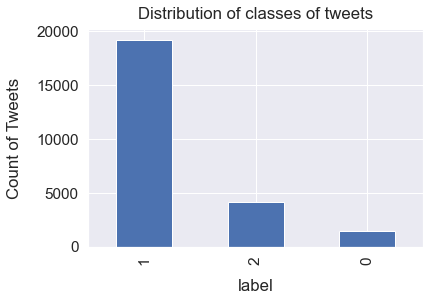

In [5]:
print("Count of values:\n",data.label.value_counts()) #With this line we print the count of the values available in the label field

sns.set(font_scale=1.4) #setting the plot to be used by seaborn plotting
data['label'].value_counts().plot(kind='bar') #the plot is created with the plot method.
plt.xlabel("label", labelpad=14) #labels and tittle are set.
plt.ylabel("Count of Tweets", labelpad=14)
plt.title("Distribution of classes of tweets", y=1.02)

We can see that the dataset is unbalanced, which is a problem for our model. Indeed, since the "hate" speech is under represented in the sample, the model might not get a high recall metric for such label. For this, we will implement simple balancing techniques later on. 

# Prepare the data for model

Now, we prepared the database for the mode. This includes cleaning the text and balancing the data. 

In [6]:
data["processed_tweet"] = data["tweet"].apply(clean_tweets)

data

,label,tweet,processed_tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...,As a woman you shouldnt complain about clean...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dats coldtyga dwn bad for cuffin dat hoe...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,Dawg You ever fuck a bitch and she start to...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,she look like a tranny
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,The shit you hear about me might be true or ...
...,...,...,...
24778,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,yous a muthafin lie 8220 right His TL is tra...
24779,2,"you've gone and broke the wrong heart baby, an...",youve gone and broke the wrong heart baby and ...
24780,1,young buck wanna eat!!.. dat nigguh like I ain...,young buck wanna eat dat nigguh like I aint fu...
24781,1,youu got wild bitches tellin you lies,youu got wild bitches tellin you lies


In [7]:
data = shuffle(data,random_state =1)

In [8]:
train, test = train_test_split(data, test_size=0.2, random_state = 1)

In [9]:
print("Labels for testing dataset:\n",test.label.value_counts(),"\n")
print("Labels for training dataset:\n",train.label.value_counts())

Labels for testing dataset:
 1    3891
2     785
0     281
Name: label, dtype: int64 

Labels for training dataset:
 1    15299
2     3378
0     1149
Name: label, dtype: int64


Now we use the training set to do some simple balancing techniques.
We will perform an undersampling of the class 1 (offensive) and at the same time we will oversample the other classes 0 (hate) and 2 (normal).

In [10]:
#first we split the data according to the class. 
hate = train[train.label==0]
offensive = train[train.label==1]
normal = train[train.label==2]

The length of the new training set will be set by increasing the normal observations in the same amount as decreasing the offensive observations.  

In [11]:
sample_size = int(len(normal) + ((len(offensive)-len(normal))/2))
sample_size

9338

Now we go ahead and balance the data. 

In [12]:
normal_overSampled = resample(normal, #we will resample the violent tweets
                              replace = True, #we set replacement to False, since we need to resample several times the same observations
                               n_samples = sample_size, #we match both samples
                               random_state = 1) # we keep reproducible results

hate_overSampled = resample(hate, 
                              replace = True, 
                               n_samples = sample_size,
                               random_state = 1) 

offensive_underSampled = resample(offensive, 
                              replace = False, 
                               n_samples = sample_size, 
                               random_state = 1) 

In [13]:
train = pd.concat([normal_overSampled, hate_overSampled, offensive_underSampled])
print("New labels for training dataset:\n",train.label.value_counts())

New labels for training dataset:
 2    9338
0    9338
1    9338
Name: label, dtype: int64


Now we prepare the dataframe for a vectorizer transformation. 

In [14]:
train_x = list(train["processed_tweet"])
test_x = list(test["processed_tweet"])

train_y = list(train["label"])
test_y = list(test["label"])

Now we use a vectorizer creating a dictionary with 2000 terms.

In [15]:
vocabulary_size = 2000
vectorizer = CountVectorizer(max_features=vocabulary_size)
features_train = vectorizer.fit_transform(train_x).toarray()
features_test = vectorizer.transform(test_x).toarray()
vocabulary = vectorizer.vocabulary_

In [16]:
dump(vectorizer,"data/vectorizer.joblib")

['data/vectorizer.joblib']

The dictionary is saved to be consulted later for new tweets. 

In [17]:
for i in vocabulary:
    vocabulary[i] = vocabulary[i].item()
    
with open(f"data/vocabulary.json", "w") as file:
    json.dump(vocabulary,file)

The features dataframes are replaced by the transformed vectorizer. 


In [18]:
train_x = features_train
test_x = features_test

Two models are to be estimated with the training data. We will evaluate which one offers the best performance and will be used in the deployment of the app. 

# SVM model

In [18]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [19]:
svm_clf = SVC(kernel='rbf', gamma=0.1, C=1.0)

In [23]:
svm_clf.fit(train_x, train_y)

SVC(gamma=0.1)

In [25]:
dump(svm_clf, 'data/svm_model.joblib')

['data/svm_model.joblib']

In [19]:
svm_clf = load('data/svm_model.joblib')

In [20]:
print_score(svm_clf, train_x, train_y, test_x, test_y, train=True)
print_score(svm_clf, train_x, train_y, test_x, test_y, train=False)

Train Result:
Accuracy Score: 97.78%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1            2  accuracy     macro avg  \
precision     0.977389     0.986922     0.969596  0.977797      0.977969   
recall        0.985971     0.953630     0.993789  0.977797      0.977797   
f1-score      0.981661     0.969991     0.981543  0.977797      0.977732   
support    9338.000000  9338.000000  9338.000000  0.977797  28014.000000   

           weighted avg  
precision      0.977969  
recall         0.977797  
f1-score       0.977732  
support    28014.000000  
_______________________________________________
Confusion Matrix: 
 [[9207   75   56]
 [ 198 8905  235]
 [  15   43 9280]]

Test Result:
Accuracy Score: 87.05%
_______________________________________________
CLASSIFICATION REPORT:
                    0            1           2  accuracy    macro avg  \
precision    0.363014     0.945931    0.734990  0.870486     0.681312   
reca

# XGBoost Model

In [ ]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier()

In [31]:
xgb_clf.fit(train_x, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', ...)

In [32]:
dump(xgb_clf,"data/xgb_model.joblib")

['data/xgb_model.joblib']

In [20]:
xgb_clf = load('data/xgb_model.joblib')

In [21]:
print_score(xgb_clf, train_x, train_y, test_x, test_y, train=True)
print_score(xgb_clf, train_x, train_y, test_x, test_y, train=False)

Train Result:
Accuracy Score: 90.99%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1            2  accuracy     macro avg  \
precision     0.915693     0.925115     0.892004  0.909866      0.910938   
recall        0.881666     0.859927     0.988006  0.909866      0.909866   
f1-score      0.898358     0.891331     0.937554  0.909866      0.909081   
support    9338.000000  9338.000000  9338.000000  0.909866  28014.000000   

           weighted avg  
precision      0.910938  
recall         0.909866  
f1-score       0.909081  
support    28014.000000  
_______________________________________________
Confusion Matrix: 
 [[8233  571  534]
 [ 725 8030  583]
 [  33   79 9226]]

Test Result:
Accuracy Score: 83.80%
_______________________________________________
CLASSIFICATION REPORT:
                    0            1           2  accuracy    macro avg  \
precision    0.278660     0.971548    0.715509  0.838007     0.655239   
reca

We see that the XGBoost model shows a higher recall for the label 0, meaning it is more effective to find the hate speech in tweets. For this reason we use the XGBoost model in the app. 